**하나의 하이퍼 파라미터를 이용해서 reculsively하게 구해보기**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 모델 구성하기

In [2]:
data = pd.read_csv('./TrafficData/4-Copy1.csv')
data = data['volumn']
sequence_length = 1440
pred_len = 1

In [3]:
from torch import FloatTensor as FloatTensor

In [4]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length-pred_len):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [5]:
split = 10080

In [6]:
seed = 42

In [7]:
device = torch.device("cuda:0")

In [8]:
X_test = torch.FloatTensor(data.iloc[-split-sequence_length:-split].values).to(device)
# X_train의 마지막 인덱스에서 sequece_length만큼 뒤에 부분을 잘라오기
X_test = X_test.view(1,1,sequence_length)

In [9]:
target = data.iloc[-split]
target = FloatTensor([target]).view(-1,1)
target

tensor([[90520.]])

In [10]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x) 

# 2. Train-Validation set으로 쪼개기

In [11]:
data

0        104771
1        101830
2        100160
3        100484
4         97533
          ...  
38875     91244
38876     88830
38877     92001
38878     88159
38879     91109
Name: volumn, Length: 38880, dtype: int64

* 10080개는 test set 
* 28800개 중 0.2의 비율인 1440*4 = 5760개는 validation set
* 28800개 중 0.8의 비율인 28800-5760 = 23040개는 train set

In [12]:
train = data.iloc[:-split-5760]
val = data.iloc[-split-5760:-split]
x_train,y_train = seq_data(train,sequence_length=1440,pred_len=1)
x_val,y_val = seq_data(val,sequence_length=1440,pred_len=1)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_181445/4291513198.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [13]:
next(iter(validation))[0].size()

torch.Size([64, 1, 1440])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [14]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(1440)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = SMAPE()
num_epochs = 100
n= len(training)

### 기본 모델 training

In [15]:
import copy

In [16]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss = 200
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs[:,:,train_index])
        # defining loss
        outputs = outputs.view(-1,1)
        labels = labels.view(-1,1)
        
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
        
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 46.223
changed
changed
changed
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 40.501
Epoch [41]/[100] running accumulative loss across all batches: 42.440
changed
Epoch [61]/[100] running accumulative loss across all batches: 41.816
Epoch [81]/[100] running accumulative loss across all batches: 40.347


### validation set에 대해서 attribution 구하기

In [17]:
n = len(validation)
n

68

In [19]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,1440))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [20]:
len(nt_ig_attr_score)

1440

<AxesSubplot: >

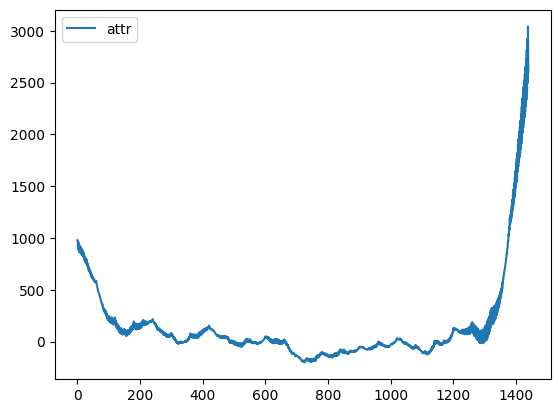

In [21]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

#### scaling

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
attr_df

,attr
0,1.912373
1,1.899713
2,1.726653
3,1.867390
4,1.698622
...,...
1435,5.207250
1436,6.389234
1437,5.411884
1438,6.664996


#### train_index구하기

In [23]:
train_idx = list(attr_df[(attr_df['attr']>0.01) | (attr_df['attr']<-0.01)].index)

In [24]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[[ 99460.,  90047.,  97806.,  ..., 109476., 107938., 110427.]],

        [[ 90047.,  97806.,  87141.,  ..., 107938., 110427., 112393.]],

        [[ 97806.,  87141.,  94147.,  ..., 110427., 112393., 107838.]],

        ...,

        [[ 74547.,  76519.,  69353.,  ...,  89959.,  83763., 150861.]],

        [[ 76519.,  69353.,  72669.,  ...,  83763., 150861.,  84639.]],

        [[ 69353.,  72669.,  67592.,  ..., 150861.,  84639.,  88357.]]],
       device='cuda:0') tensor([[[112393.]],

        [[107838.]],

        [[109474.]],

        [[106154.]],

        [[109562.]],

        [[104609.]],

        [[108481.]],

        [[104811.]],

        [[108068.]],

        [[101610.]],

        [[109562.]],

        [[102103.]],

        [[107085.]],

        [[101324.]],

        [[103611.]],

        [[ 97023.]],

        [[103033.]],

        [[ 97762.]],

        [[102938.]],

        [[ 95425.]],

        [[100112.]],

        [[ 92605.]],

        [[ 97253.]],

        [[ 92184.]

tensor([[[122832., 124781., 119598.,  ..., 114678., 108299., 116605.]],

        [[124781., 119598., 123730.,  ..., 108299., 116605., 110747.]],

        [[119598., 123730., 119568.,  ..., 116605., 110747., 112762.]],

        ...,

        [[ 88463.,  95853.,  91505.,  ...,  92405.,  84943.,  90399.]],

        [[ 95853.,  91505.,  93862.,  ...,  84943.,  90399.,  82495.]],

        [[ 91505.,  93862.,  92083.,  ...,  90399.,  82495.,  89415.]]],
       device='cuda:0') tensor([[[110747.]],

        [[112762.]],

        [[110293.]],

        [[113873.]],

        [[108765.]],

        [[112369.]],

        [[109762.]],

        [[111661.]],

        [[108259.]],

        [[109329.]],

        [[106382.]],

        [[106949.]],

        [[104458.]],

        [[107824.]],

        [[105875.]],

        [[108803.]],

        [[104063.]],

        [[106877.]],

        [[103065.]],

        [[104142.]],

        [[100373.]],

        [[103555.]],

        [[101054.]],

        [[102112.]

tensor([[[124733., 134986., 128945.,  ..., 111042., 111987., 110422.]],

        [[134986., 128945., 134478.,  ..., 111987., 110422., 114462.]],

        [[128945., 134478., 129819.,  ..., 110422., 114462., 108756.]],

        ...,

        [[ 99807.,  98408., 101163.,  ...,  84900.,  82091.,  85870.]],

        [[ 98408., 101163.,  99855.,  ...,  82091.,  85870.,  82298.]],

        [[101163.,  99855., 100490.,  ...,  85870.,  82298.,  85843.]]],
       device='cuda:0') tensor([[[114462.]],

        [[108756.]],

        [[114250.]],

        [[108517.]],

        [[112000.]],

        [[107422.]],

        [[111597.]],

        [[106284.]],

        [[111207.]],

        [[105006.]],

        [[110485.]],

        [[103961.]],

        [[107469.]],

        [[101773.]],

        [[106755.]],

        [[100077.]],

        [[107486.]],

        [[ 99584.]],

        [[103786.]],

        [[ 95752.]],

        [[104118.]],

        [[ 96691.]],

        [[101723.]],

        [[ 96230.]

tensor([[[130023., 121588., 128907.,  ..., 137831., 130055., 136399.]],

        [[121588., 128907., 120364.,  ..., 130055., 136399., 130159.]],

        [[128907., 120364., 127777.,  ..., 136399., 130159., 134084.]],

        ...,

        [[ 94770.,  98085.,  93727.,  ..., 101465., 107056., 100620.]],

        [[ 98085.,  93727.,  97152.,  ..., 107056., 100620., 103395.]],

        [[ 93727.,  97152.,  93410.,  ..., 100620., 103395.,  99170.]]],
       device='cuda:0') tensor([[[130159.]],

        [[134084.]],

        [[128385.]],

        [[135154.]],

        [[127417.]],

        [[135997.]],

        [[125619.]],

        [[131141.]],

        [[122579.]],

        [[132631.]],

        [[121583.]],

        [[129175.]],

        [[118560.]],

        [[126914.]],

        [[117476.]],

        [[124864.]],

        [[116938.]],

        [[127005.]],

        [[121521.]],

        [[127115.]],

        [[118753.]],

        [[121881.]],

        [[120024.]],

        [[122350.]

In [25]:
val_x

tensor([[[ 97152.,  93410.,  97749.,  ..., 103395.,  99170., 103273.]],

        [[ 93410.,  97749.,  92393.,  ...,  99170., 103273.,  97323.]],

        [[ 97749.,  92393.,  94468.,  ..., 103273.,  97323., 102155.]],

        ...,

        [[ 85870.,  82298.,  85843.,  ...,  91668.,  87325.,  91681.]],

        [[ 82298.,  85843.,  85797.,  ...,  87325.,  91681.,  88167.]],

        [[ 85843.,  85797.,  90281.,  ...,  91681.,  88167.,  89379.]]],
       device='cuda:0')

## 이전 과정에서 train_idx를 한번 구했음

In [26]:
import copy

In [27]:
n = len(training)
num_epochs = 100
criterion = SMAPE()
out_list = []
len_list = []
index_list = []
reculsive_attr_list = []

hyper_parameter = 0.01
for i in range(50): # 50번의 반복
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언
    
    minimal_loss = 200
    
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    best_model = model
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs[:,:,train_idx])
            
            outputs = outputs.view(-1,1)
            
            labels = labels.view(-1,1)
        
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f' Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
            
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    # 모델 Fully-Training 완료
    
    
    # Fully-Training 모델을 이용해서 예측
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x[:,:,train_idx])
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
        
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    
    result = criterion(pred,val_target).item()*100
    out_list.append(result)
    
    
    # 다음 Training을 위한 새로운 train_idx를 찾는 과정 (scaler를 사용
    cnt = 0
    ig = IntegratedGradients(model)
    nt_ig = NoiseTunnel(ig)
    nt_ig_attr_score = torch.zeros((1,len(train_idx)))
    for val in validation:
        temp_n = val[0].size(0)
        temp = nt_ig.attribute(val[0][:,:,train_idx]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음[train_idx만 평가대상]
        nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
        cnt = cnt + temp_n
    nt_ig_attr_score = nt_ig_attr_score/cnt
    nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)
    
    # scaling 을 통해서 train_idx를 찾는다.
    scaler = StandardScaler()
    attr_df = scaler.fit_transform(nt_ig_attr_score.reshape(-1,1))
    attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)},index = train_idx) # train_index를 index로 갖음)
    train_idx = list(attr_df[(attr_df['attr']>hyper_parameter) | (attr_df['attr']<-hyper_parameter)].index) # train_index업데이트
   

    # 결과 기록
    len_list.append(len(train_idx))
    index_list.append(train_idx)
    reculsive_attr_list.append(attr_df)
    

changed
changed
changed
changed
changed
changed
changed
changed
 Training 완료 마지막 Epoch loss:50.409898921549754
changed
changed
changed
changed
changed
changed
changed
 Training 완료 마지막 Epoch loss:46.63409020547816
changed
changed
changed
 Training 완료 마지막 Epoch loss:48.567556831214205
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
 Training 완료 마지막 Epoch loss:37.13492254076316
changed
changed
changed
changed
changed
 Training 완료 마지막 Epoch loss:36.65483896262371
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
 Training 완료 마지막 Epoch loss:46.7036725220287
changed
changed
changed
changed
 Training 완료 마지막 Epoch loss:45.26803542311529
changed
changed
changed
changed
 Training 완료 마지막 Epoch loss:30.047751380924204
changed
changed
changed
changed
changed
changed
 Training 완료 마지막 Epoch loss:46.46632512507839
changed
changed
changed
changed
changed
 Training 완료 마지막 Epoch loss:32.8048318200166
changed
changed
changed
cha

In [28]:
len_list

[1406,
 1379,
 1375,
 1367,
 1346,
 1314,
 1280,
 1274,
 1258,
 1232,
 1220,
 1195,
 1187,
 1173,
 1153,
 1141,
 1128,
 1124,
 1114,
 1100,
 1090,
 1084,
 1068,
 1058,
 1049,
 1048,
 1041,
 1035,
 1024,
 1019,
 1007,
 1000,
 998,
 992,
 981,
 979,
 977,
 964,
 962,
 947,
 933,
 927,
 920,
 906,
 897,
 881,
 873,
 869,
 866,
 862]

In [29]:
out_df = pd.DataFrame({"out":out_list})

<AxesSubplot: >

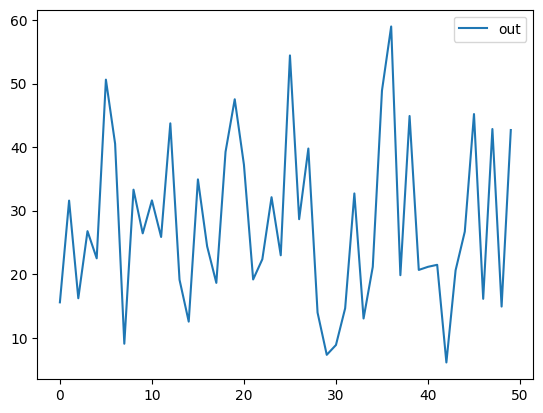

In [30]:
out_df.plot()